In [283]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [284]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from src.features.cleaning import clean_data, split_X_and_y_data
from src.utils import get_project_root

## Pre-processing (TODO: recode tumor size and check for other known descriptors like the MGMT gene and prescence of genetic mutation)

In [285]:
# dir_root = get_project_root()
dir_data = './data'
filename_data_brain = os.path.join(
    # dir_root,
    dir_data,
    'survival_brain_2000_to_2020_seer_2022_db.csv'
)
data_raw = pd.read_csv(filename_data_brain)

/tmp/ipykernel_66730/520045369.py:8: DtypeWarning: Columns (102) have mixed types. Specify dtype option on import or set low_memory=False.
  data_raw = pd.read_csv(filename_data_brain)


In [286]:
data = clean_data(data_raw)

In [287]:
from sklearn.model_selection import train_test_split
from sksurv.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.feature_selection import SelectKBest
from scipy import stats

In [288]:
data_train, data_test = train_test_split(
    data,
    test_size=0.2,
    random_state=2984,
    shuffle=True,
    stratify=data['Vital status recode (study cutoff used)']
)

X_train, y_train = split_X_and_y_data(data_train)
X_test, y_test = split_X_and_y_data(data_test)

In [289]:
X_train.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 61133 entries, 51318 to 31221
Data columns (total 125 columns):
 #    Column                                                                 Non-Null Count  Dtype   
---   ------                                                                 --------------  -----   
 0    Age recode with <1 year olds                                           61133 non-null  int64   
 1    Sex                                                                    61133 non-null  category
 2    Year of diagnosis                                                      61133 non-null  int64   
 3    PRCDA 2020                                                             61133 non-null  object  
 4    Race recode (W, B, AI, API)                                            61133 non-null  category
 5    Origin recode NHIA (Hispanic, Non-Hisp)                                61133 non-null  category
 6    Race and origin recode (NHW, NHB, NHAIAN, NHAPI, Hispanic)           

In [290]:
def get_training_subset(X_train):
    categorical_columns = [
        'Sex',
        'Race recode (W, B, AI, API)',
        'Origin recode NHIA (Hispanic, Non-Hisp)',
        'Race and origin recode (NHW, NHB, NHAIAN, NHAPI, Hispanic)',
        # 'SEER cause-specific death classification',
        # 'SEER other cause of death classification',
        'Type of Reporting Source',
        'Marital status at diagnosis',
        'Rural-Urban Continuum Code',
        # 'End Calc Vital Status (Adjusted)',
    ]
    numerical_columns = [
        'Year of diagnosis',
        # 'Year of follow-up recode',
        'Total number of in situ/malignant tumors for patient',
        # 'Year of diagnosis (2000-2019 by 5)',
    ]
    other_useful_columns = [
        # 'Alive at last contact',
        'Age recode with <1 year olds',
        'Median household income inflation adj to 2021 (thousands USD)'
    ]
    all_useful_columns = categorical_columns + \
        numerical_columns + other_useful_columns

    # Make a smaller dataframe for testing
    X_subset_train = X_train[all_useful_columns]
    assert all(X_subset_train.isna() == False)
    return X_subset_train

In [291]:
X_subset_train = get_training_subset(X_train)
X_subset_train.head()

,Sex,"Race recode (W, B, AI, API)","Origin recode NHIA (Hispanic, Non-Hisp)","Race and origin recode (NHW, NHB, NHAIAN, NHAPI, Hispanic)",Type of Reporting Source,Marital status at diagnosis,Rural-Urban Continuum Code,Year of diagnosis,Total number of in situ/malignant tumors for patient,Age recode with <1 year olds,Median household income inflation adj to 2021 (thousands USD)
51318,Male,White,Non-Spanish-Hispanic-Latino,Non-Hispanic White,Hospital inpatient/outpatient or clinic,Married (including common law),Counties in metropolitan areas ge 1 million pop,2019,1,65,75
53949,Male,White,Non-Spanish-Hispanic-Latino,Non-Hispanic White,Hospital inpatient/outpatient or clinic,Married (including common law),Counties in metropolitan areas ge 1 million pop,2009,1,65,75
31599,Male,White,Non-Spanish-Hispanic-Latino,Non-Hispanic White,Hospital inpatient/outpatient or clinic,Single (never married),Counties in metropolitan areas ge 1 million pop,2009,1,50,75
44685,Female,White,Non-Spanish-Hispanic-Latino,Non-Hispanic White,Hospital inpatient/outpatient or clinic,Married (including common law),Counties in metropolitan areas ge 1 million pop,2013,1,60,60
25873,Male,Asian or Pacific Islander,Non-Spanish-Hispanic-Latino,Non-Hispanic Asian or Pacific Islander,Other hospital outpatient unit or surgery cent...,Married (including common law),Counties in metropolitan areas ge 1 million pop,2020,1,50,75


In [292]:
# One-hot encoding for categorical columns
X_train_numeric = OneHotEncoder().fit_transform(X_subset_train)
data_x_numeric = X_train_numeric
X_train_numeric.head()

,Sex=Male,"Race recode (W, B, AI, API)=Asian or Pacific Islander","Race recode (W, B, AI, API)=Black","Race recode (W, B, AI, API)=Unknown","Race recode (W, B, AI, API)=White","Origin recode NHIA (Hispanic, Non-Hisp)=Spanish-Hispanic-Latino","Race and origin recode (NHW, NHB, NHAIAN, NHAPI, Hispanic)=Non-Hispanic American Indian/Alaska Native","Race and origin recode (NHW, NHB, NHAIAN, NHAPI, Hispanic)=Non-Hispanic Asian or Pacific Islander","Race and origin recode (NHW, NHB, NHAIAN, NHAPI, Hispanic)=Non-Hispanic Black","Race and origin recode (NHW, NHB, NHAIAN, NHAPI, Hispanic)=Non-Hispanic Unknown Race",...,Marital status at diagnosis=Widowed,"Rural-Urban Continuum Code=Counties in metropolitan areas of 250,000 to 1 million pop",Rural-Urban Continuum Code=Counties in metropolitan areas of lt 250 thousand pop,Rural-Urban Continuum Code=Nonmetropolitan counties adjacent to a metropolitan area,Rural-Urban Continuum Code=Nonmetropolitan counties not adjacent to a metropolitan area,Rural-Urban Continuum Code=Unknown/missing/no match (Alaska or Hawaii - Entire State),Year of diagnosis,Total number of in situ/malignant tumors for patient,Age recode with <1 year olds,Median household income inflation adj to 2021 (thousands USD)
51318,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2019,1,65,75
53949,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2009,1,65,75
31599,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2009,1,50,75
44685,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2013,1,60,60
25873,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2020,1,50,75


In [293]:
y_train

,Event indicator,Survival months
51318,False,19
53949,True,8
31599,True,15
44685,True,6
25873,False,6
...,...,...
24847,True,4
30983,False,18
43639,True,1
35957,True,13


In [294]:
data_y = y_train.to_records(index=False)
data_y

rec.array([(False, 19), ( True,  8), ( True, 15), ..., ( True,  1),
           ( True, 13), ( True, 25)],
          dtype=[('Event indicator', '?'), ('Survival months', '<i8')])

## Model training

In [295]:
from sksurv.nonparametric import kaplan_meier_estimator
from sksurv.linear_model import CoxPHSurvivalAnalysis, CoxnetSurvivalAnalysis
from sksurv.metrics import concordance_index_censored

In [296]:
Xt = data_x_numeric
y = data_y

alphas = 10.0 ** np.linspace(-2, 6, 20)
coefficients = {}
scores = []

cph = CoxPHSurvivalAnalysis()
for alpha in alphas:
    cph.set_params(alpha=alpha)
    cph.fit(Xt, y)
    score = cph.score(Xt, y)
    scores.append(score)
    key = round(alpha, 5)
    coefficients[key] = cph.coef_

coefficients = pd.DataFrame.from_dict(coefficients).rename_axis(
    index="feature", columns="alpha").set_index(Xt.columns)

In [312]:
# Lower alpha values result in larger coefficients and a higher c-index
for (i, alpha) in enumerate(alphas):
    print(f'alpha={alpha:.2g},\t\tc-index={scores[i]:.9f}')

alpha=0.01,		c-index=0.744570213
alpha=0.026,		c-index=0.744570240
alpha=0.07,		c-index=0.744570158
alpha=0.18,		c-index=0.744570227
alpha=0.48,		c-index=0.744570434
alpha=1.3,		c-index=0.744570675
alpha=3.4,		c-index=0.744569371
alpha=8.9,		c-index=0.744563738
alpha=23,		c-index=0.744550316
alpha=62,		c-index=0.744500268
alpha=1.6e+02,		c-index=0.744362291
alpha=4.3e+02,		c-index=0.744049228
alpha=1.1e+03,		c-index=0.743430263
alpha=3e+03,		c-index=0.742453438
alpha=7.8e+03,		c-index=0.741271469
alpha=2.1e+04,		c-index=0.740156617
alpha=5.5e+04,		c-index=0.739304458
alpha=1.4e+05,		c-index=0.738789310
alpha=3.8e+05,		c-index=0.738455869
alpha=1e+06,		c-index=0.738111362


In [298]:
def plot_coefficients(coefs, n_highlight):
    _, ax = plt.subplots(figsize=(9, 6))
    n_features = coefs.shape[0]
    alphas = coefs.columns
    for row in coefs.itertuples():
        ax.semilogx(alphas, row[1:], ".-", label=row.Index)

    alpha_min = alphas.min()
    top_coefs = coefs.loc[:, alpha_min].map(abs).sort_values().tail(n_highlight)
    for name in top_coefs.index:
        coef = coefs.loc[name, alpha_min]
        plt.text(alpha_min, coef, name + "   ", horizontalalignment="right", verticalalignment="center")

    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    ax.grid(True)
    ax.set_xlabel("alpha")
    ax.set_ylabel("coefficient")

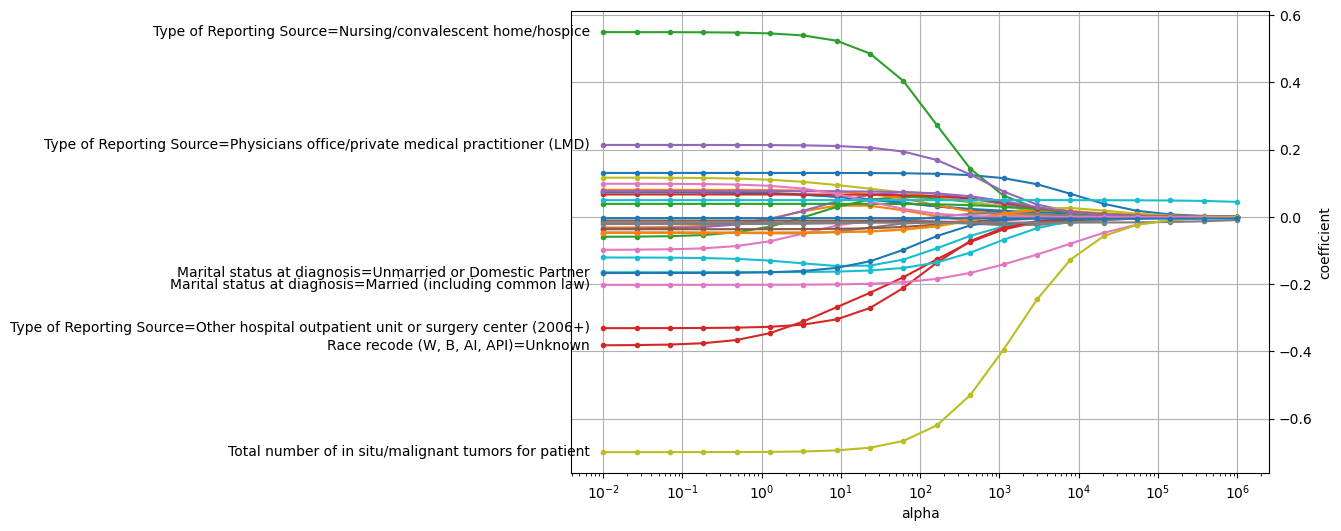

In [299]:
plot_coefficients(coefficients, n_highlight=7)

In [300]:
# cox_lasso = CoxnetSurvivalAnalysis(l1_ratio=1.0, alpha_min_ratio=1e-30)
cox_lasso = CoxnetSurvivalAnalysis(
    l1_ratio=1.0, alpha_min_ratio=1e-30, fit_baseline_model=True)
cox_lasso.fit(Xt, y)
print(f'c-index={cox_lasso.score(Xt, y)}')

c-index=0.744561872887329


In [301]:
# Actual set of estimated alphas used by the model
cox_lasso.alphas_

array([9.10311330e+00, 4.53064094e+00, 2.25491067e+00, 1.12227435e+00,
       5.58558591e-01, 2.77995927e-01, 1.38359228e-01, 6.88617137e-02,
       3.42726372e-02, 1.70575723e-02, 8.48959393e-03, 4.22529090e-03,
       2.10293724e-03, 1.04663682e-03, 5.20913611e-04, 2.59259932e-04,
       1.29034279e-04, 6.42206647e-05, 3.19627762e-05, 1.59079490e-05])

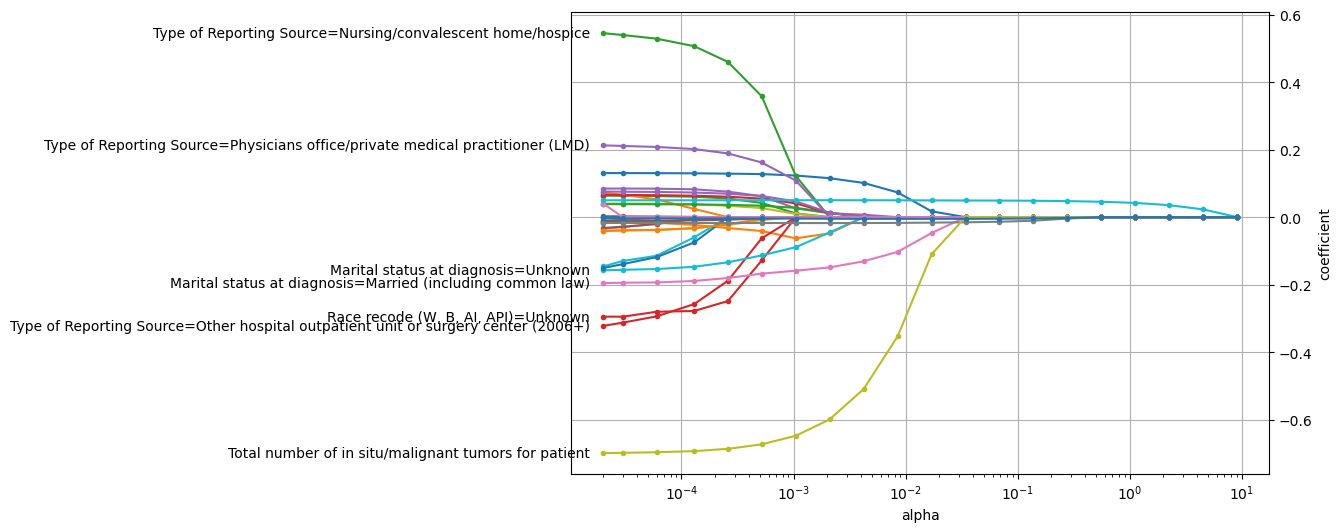

In [302]:
coefficients_lasso = pd.DataFrame(
    cox_lasso.coef_, index=Xt.columns, columns=np.round(cox_lasso.alphas_, 5))

plot_coefficients(coefficients_lasso, n_highlight=7)

In [303]:
# cox_elastic_net = CoxnetSurvivalAnalysis(l1_ratio=0.1, alpha_min_ratio=1e-50)
cox_elastic_net = CoxnetSurvivalAnalysis(
    l1_ratio=0.1, alpha_min_ratio=1e-50, fit_baseline_model=True)
cox_elastic_net.fit(Xt, y)
print(f'c-index={cox_elastic_net.score(Xt, y)}')

c-index=0.7445683754975188


In [304]:
# Actual set of estimated alphas used by the model
cox_elastic_net.alphas_

array([9.10311330e+01, 2.84537455e+01, 8.89383233e+00, 2.77995927e+00,
       8.68936275e-01, 2.71604789e-01, 8.48959393e-02, 2.65360583e-02,
       8.29441780e-03, 2.59259932e-03, 8.10372878e-04, 2.53299535e-04,
       7.91742371e-05, 2.47476168e-05, 7.73540180e-06])

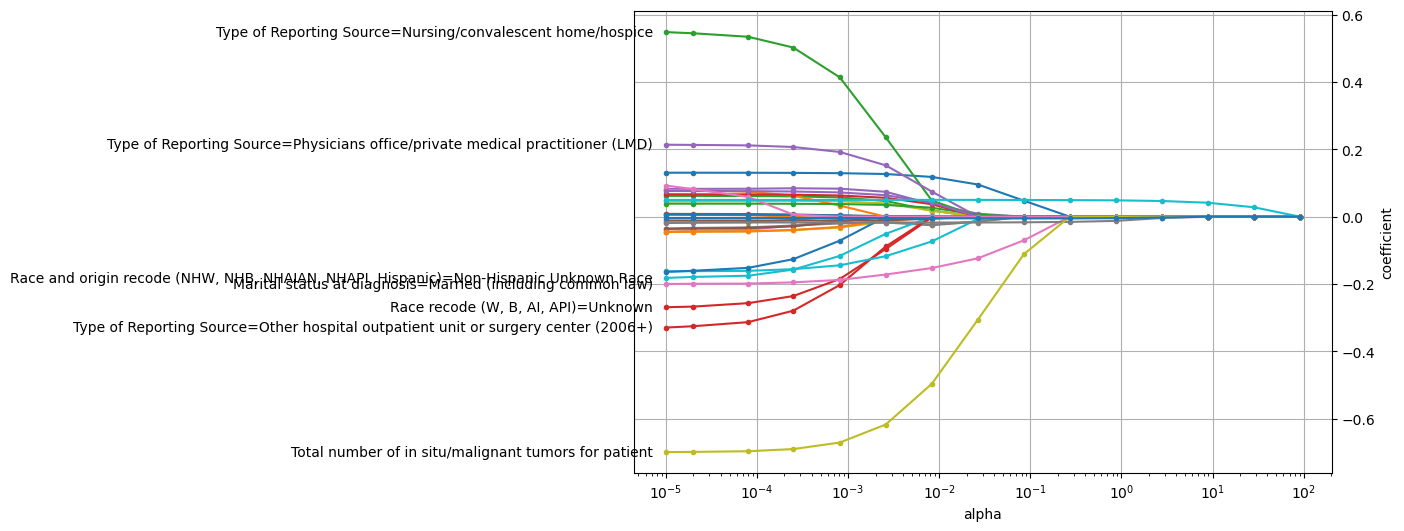

In [305]:
coefficients_elastic_net = pd.DataFrame(
    cox_elastic_net.coef_, index=Xt.columns, columns=np.round(
        cox_elastic_net.alphas_, 5)
)

plot_coefficients(coefficients_elastic_net, n_highlight=7)

## Prediction

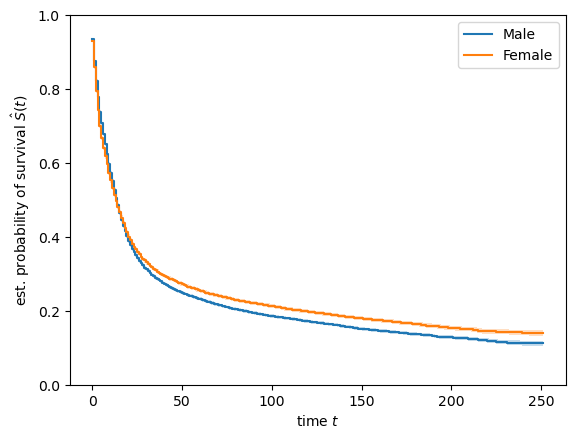

In [306]:
for sex in ("Male", "Female"):
    mask_sex = X_train["Sex"] == sex
    time_sex, survival_prob_sex, conf_int = kaplan_meier_estimator(
        y_train["Event indicator"][mask_sex],
        y_train["Survival months"][mask_sex],
        conf_type="log-log",
    )

    plt.step(time_sex, survival_prob_sex,
             where="post", label=sex)
    plt.fill_between(
        time_sex, conf_int[0], conf_int[1], alpha=0.25, step="post")

plt.ylim(0, 1)
plt.ylabel(r"est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.legend(loc="best")

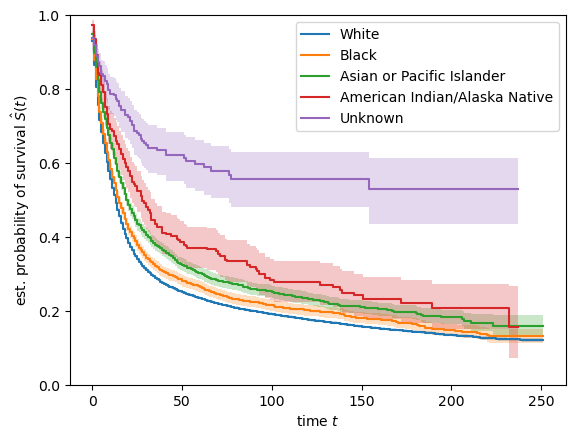

In [307]:
for race_recode in ("White", "Black", "Asian or Pacific Islander", "American Indian/Alaska Native", "Unknown"):
    mask_race = X_subset_train["Race recode (W, B, AI, API)"] == race_recode
    time_race, survival_prob_race, conf_int = kaplan_meier_estimator(
        y_train["Event indicator"][mask_race],
        y_train["Survival months"][mask_race],
        conf_type="log-log",
    )

    plt.step(time_race, survival_prob_race,
             where="post", label=race_recode)
    plt.fill_between(
        time_race, conf_int[0], conf_int[1], alpha=0.25, step="post")

plt.ylim(0, 1)
plt.ylabel(r"est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.legend(loc="best")

In [308]:
first_case = data_x_numeric.iloc[0]
synthetic_cases = [first_case.copy() for i in range(4)]
synthetic_ages = [51, 6, 80, 30]
for synthetic_case, synthetic_age in zip(synthetic_cases, synthetic_ages):
    synthetic_case['Age recode with <1 year olds'] = synthetic_age

print("Synthetic ages:", list(map(lambda x: x['Age recode with <1 year olds'], synthetic_cases)))

Synthetic ages: [51.0, 6.0, 80.0, 30.0]


In [309]:
X_to_pred = pd.DataFrame.from_dict(
    {i: synthetic_case for i, synthetic_case in enumerate(synthetic_cases)},
    columns=data_x_numeric.columns,
    orient="index",
)
X_to_pred

,Sex=Male,"Race recode (W, B, AI, API)=Asian or Pacific Islander","Race recode (W, B, AI, API)=Black","Race recode (W, B, AI, API)=Unknown","Race recode (W, B, AI, API)=White","Origin recode NHIA (Hispanic, Non-Hisp)=Spanish-Hispanic-Latino","Race and origin recode (NHW, NHB, NHAIAN, NHAPI, Hispanic)=Non-Hispanic American Indian/Alaska Native","Race and origin recode (NHW, NHB, NHAIAN, NHAPI, Hispanic)=Non-Hispanic Asian or Pacific Islander","Race and origin recode (NHW, NHB, NHAIAN, NHAPI, Hispanic)=Non-Hispanic Black","Race and origin recode (NHW, NHB, NHAIAN, NHAPI, Hispanic)=Non-Hispanic Unknown Race",...,Marital status at diagnosis=Widowed,"Rural-Urban Continuum Code=Counties in metropolitan areas of 250,000 to 1 million pop",Rural-Urban Continuum Code=Counties in metropolitan areas of lt 250 thousand pop,Rural-Urban Continuum Code=Nonmetropolitan counties adjacent to a metropolitan area,Rural-Urban Continuum Code=Nonmetropolitan counties not adjacent to a metropolitan area,Rural-Urban Continuum Code=Unknown/missing/no match (Alaska or Hawaii - Entire State),Year of diagnosis,Total number of in situ/malignant tumors for patient,Age recode with <1 year olds,Median household income inflation adj to 2021 (thousands USD)
0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2019.0,1.0,51.0,75.0
1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2019.0,1.0,6.0,75.0
2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2019.0,1.0,80.0,75.0
3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2019.0,1.0,30.0,75.0


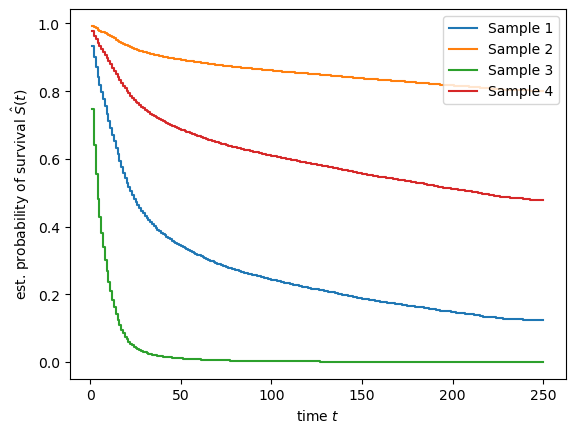

In [310]:
pred_surv = cox_lasso.predict_survival_function(X_to_pred)
time_points = np.arange(1, 251)
for i, surv_func in enumerate(pred_surv):
    plt.step(time_points, surv_func(time_points),
             where="post", label=f"Sample {i + 1}")
plt.ylabel(r"est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.legend(loc="upper right")

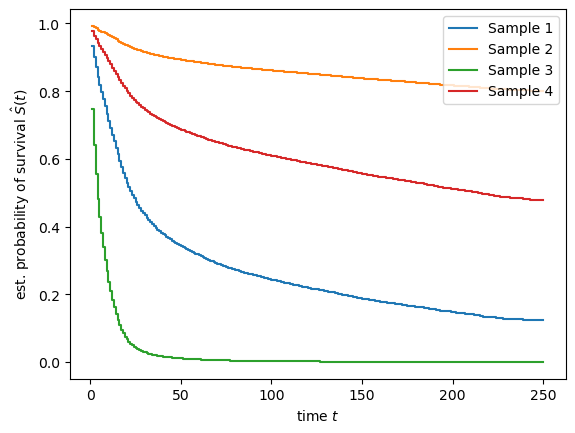

In [311]:
pred_surv = cox_elastic_net.predict_survival_function(X_to_pred)
time_points = np.arange(1, 251)
for i, surv_func in enumerate(pred_surv):
    plt.step(time_points, surv_func(time_points),
             where="post", label=f"Sample {i + 1}")
plt.ylabel(r"est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.legend(loc="upper right")

## TODO: Grid-search for best $\alpha$ and $l_1$ ratio

In [ ]:
column_transformer = make_column_transformer(
    (OneHotEncoder(), ['Sex']),
    (StandardScaler(), ['Age recode with <1 year olds']),
    remainder='drop',
    n_jobs=-1,
)

In [ ]:
pipeline = make_pipeline(
    column_transformer,
    # SelectKBest(fit_and_score_features, k=1),
    CoxnetSurvivalAnalysis(verbose=True, fit_baseline_model=True)
)

cv_search_dist = {
    'coxnetsurvivalanalysis__l1_ratio': np.linspace(0.8, 1, 5)
}
# cv_search = RandomizedSearchCV(
cv_search = GridSearchCV(
    pipeline,
    cv_search_dist,
    cv=3,
    n_jobs=-1,
)
cv_search.fit(X_train, y_train.to_records(index=False))
# cv_search.score(X_train, y_train.to_records(index=False))

In [ ]:
cv_search.score(X_train, y_train.to_records(index=False))

In [ ]:
cv_search.best_params_

In [ ]:
X_to_pred = pd.DataFrame.from_dict(
    {
        1: X_train.iloc[0],
        2: X_train.iloc[1],
    },
    columns=pd.Index(['Sex', 'Age recode with <1 year olds'],
                  dtype='object'),
    orient="index",
)
print(X_to_pred)

In [ ]:
best_estimator = cv_search.best_estimator_
pred_surv = best_estimator.predict_survival_function(X_to_pred)
time_points = np.arange(1, 251)
for i, surv_func in enumerate(pred_surv):
    plt.step(time_points, surv_func(time_points),
             where="post", label=f"Sample {i + 1}")
plt.ylabel(r"est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.legend(loc="best")